## Importation des library


In [22]:

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from math import ceil
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import re
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

## Définition de mes tools

In [23]:
# Class DataAnalysis

class DataAnalysis:
   def __init__(self, df) -> None:
      self.df = df.copy()
      self.categorical_data = df.select_dtypes(include='object')
      self.numeric_data = df.select_dtypes("number")
   
   # Numeric variable analysis
   def check_null(self) -> None:
      print(f'Nbre de valeur manquante dans la dataframe :\n {self.df.isnull().sum().sum()}')
      if (self.df.isnull().sum().sum()>1):
         print(f"Nbre de valeur manquante par colonne de la dataframe :\n {self.df.isnull().sum()} ")
   def num_boxplot(self) -> None:
      NumericAnalysis(self.numeric_data).boxplot()

   def corr_heatmap(self) -> None :
      NumericAnalysis(self.numeric_data).corr_matrix()

   # Categorical variable analysis
   def cat_summary(self) -> None :
      CategoricalAnalysis(self.categorical_data).summary()
   def cat_encode(self) -> None :
      CategoricalAnalysis(self.categorical_data).encode()
   def cat_hist(self) -> None :
      CategoricalAnalysis(self.categorical_data).hist()

      
# Class Categorical Analysis

class CategoricalAnalysis:
   def __init__(self, df) -> None:
      #On suppose df qualitative
      self.df = df.copy()
   def summary(self) -> None:
      # Comptage valeur unique et description des varaibles qualitatives
      print(self.df.describe(include='object'))

      # Comptage des modalités par variables qualitatives
      for cat in self.df :
         print(self.df[cat].value_counts())
   def encode(self, p=0.05) -> pd.DataFrame :
      data_encoded = self.df.copy()
      categorical_data = self.df.select_dtypes(include='object')
      for cat in categorical_data :
         
         columns_array = data_encoded[cat].to_numpy().reshape(-1,1)
         one_hot_encoder = OneHotEncoder(sparse_output=False).fit(columns_array)
         data_enc = one_hot_encoder.transform(columns_array)
         df_enc = pd.DataFrame(data_enc, columns = one_hot_encoder.get_feature_names_out([cat]))
         data_encoded = pd.concat([data_encoded,df_enc],axis=1)
         data_encoded = data_encoded.drop(columns=cat)

      return data_encoded
   def hist(self) -> None:

      n_cols = len(self.df.columns)
      n_rows = ceil(n_cols / 3)
      fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
      axes = axes.flatten()  # Aplatir les axes pour itérer facilement
      
      # Tracer les histogrammes
      for i, cat in enumerate(self.df):
         sns.histplot(data=self.df, x=cat, discrete=True, shrink=0.8, color='skyblue', ax=axes[i])
         axes[i].set_title(f"Distribution des modalités pour '{cat}'")
         axes[i].set_xlabel(cat)
         axes[i].set_ylabel('Nombre d\'occurrences')
         axes[i].tick_params(axis='x', rotation=45)  # Rotation des ticks pour les modalités
      
      # Supprimer les axes inutilisés si le nombre de colonnes est inférieur à la grille
      for j in range(i + 1, len(axes)):
         fig.delaxes(axes[j])
      
      # Ajustement de la mise en page
      plt.tight_layout()
      plt.show()
      
# Class Numerical Analysis

class NumericAnalysis:

   def __init__(self, numeric_data) -> None:
      self.numeric_data = numeric_data.copy()
   def boxplot(self) -> None:
      n_cols = len(self.numeric_data.columns)
      n_rows = ceil(n_cols / 3)
      
      fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows)) 
      axes = axes.flatten()  # Aplatir les axes pour itérer facilement
      
      for i, col in enumerate(self.numeric_data.columns):
         sns.boxplot(y=self.numeric_data[col], ax=axes[i])
         axes[i].set_title(f"{col}")
         axes[i].set_ylabel("Valeurs")
         axes[i].set_xlabel("")  # Pas d'étiquette pour l'axe X
      
      # Supprimer les axes inutilisés si le nombre de colonnes est inférieur à la grille
      for j in range(i + 1, len(axes)):
         fig.delaxes(axes[j])
      
      plt.tight_layout()
      plt.show()

   def corr_matrix(self) -> None:
      sns.heatmap(data=self.numeric_data.corr())

## Importation des données


In [24]:

data_raw = pd.read_csv('database/Insurance claims data.csv')

data_raw.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,steering_type,turning_radius,length,width,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6,Yes,Yes,Yes,Yes,Yes,Disc,1493,4,Automatic,Power,5.2,4300,1790,1720,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,97.89bhp@3600rpm,i-DTEC,2,No,Yes,No,Yes,Yes,Drum,1498,4,Manual,Electric,4.9,3995,1695,1051,Yes,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6,Yes,Yes,Yes,Yes,Yes,Disc,1493,4,Automatic,Power,5.2,4300,1790,1720,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,Power,4.6,3445,1515,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,88.77bhp@4000rpm,1.5 Turbocharged Revotorq,2,No,Yes,No,Yes,No,Drum,1497,4,Manual,Electric,5.0,3990,1755,1490,No,No,No,No,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


## Feature engineering


In [25]:

print(data_raw.describe())

       subscription_length   vehicle_age  customer_age  region_density  \
count         58592.000000  58592.000000  58592.000000    58592.000000   
mean              6.111688      1.388473     44.823935    18826.858667   
std               4.142790      1.134413      6.935604    17660.174792   
min               0.000000      0.000000     35.000000      290.000000   
25%               2.100000      0.400000     39.000000     6112.000000   
50%               5.700000      1.200000     44.000000     8794.000000   
75%              10.400000      2.200000     49.000000    27003.000000   
max              14.000000     20.000000     75.000000    73430.000000   

            airbags  displacement      cylinder  turning_radius        length  \
count  58592.000000  58592.000000  58592.000000    58592.000000  58592.000000   
mean       3.137066   1162.355851      3.626963        4.852893   3850.476891   
std        1.832641    266.304786      0.483616        0.228061    311.457119   
min      

In [26]:
print(data_raw.dtypes)

policy_id                            object
subscription_length                 float64
vehicle_age                         float64
customer_age                          int64
region_code                          object
region_density                        int64
segment                              object
model                                object
fuel_type                            object
max_torque                           object
max_power                            object
engine_type                          object
airbags                               int64
is_esc                               object
is_adjustable_steering               object
is_tpms                              object
is_parking_sensors                   object
is_parking_camera                    object
rear_brakes_type                     object
displacement                          int64
cylinder                              int64
transmission_type                    object
steering_type                   

## Vérification des données 


In [27]:

print('Valeurs manquantes : \n ', data_raw.isnull().sum())

Valeurs manquantes : 
  policy_id                           0
subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
steering_type                       0
turning_radius                      0
length                              0
width                     

La table n'a pas de valeur manquante, toutes les variables sont bien definies et valides

In [8]:
# Suppression colonne

data = data_raw.drop(columns=['policy_id'])

# Séparation des données

numeric_data = data.select_dtypes("number")
categorical_data = data.select_dtypes(include=["object", "category"])


In [9]:
# Initialize data_analysis class

data_analysis = DataAnalysis(data)

In [10]:
# Comptage d'occurence

data_analysis.cat_summary()

       region_code segment  model fuel_type     max_torque         max_power  \
count        58592   58592  58592     58592          58592             58592   
unique          22       6     11         3              9                 9   
top             C8      B2     M1    Petrol  113Nm@4400rpm  88.50bhp@6000rpm   
freq         13654   18314  14948     20532          17796             17796   

              engine_type is_esc is_adjustable_steering is_tpms  \
count               58592  58592                  58592   58592   
unique                 11      2                      2       2   
top     F8D Petrol Engine     No                    Yes      No   
freq                14948  40191                  35526   44574   

       is_parking_sensors is_parking_camera rear_brakes_type  \
count               58592             58592            58592   
unique                  2                 2                2   
top                   Yes                No             Drum   
freq   

## Histogramme des occurences


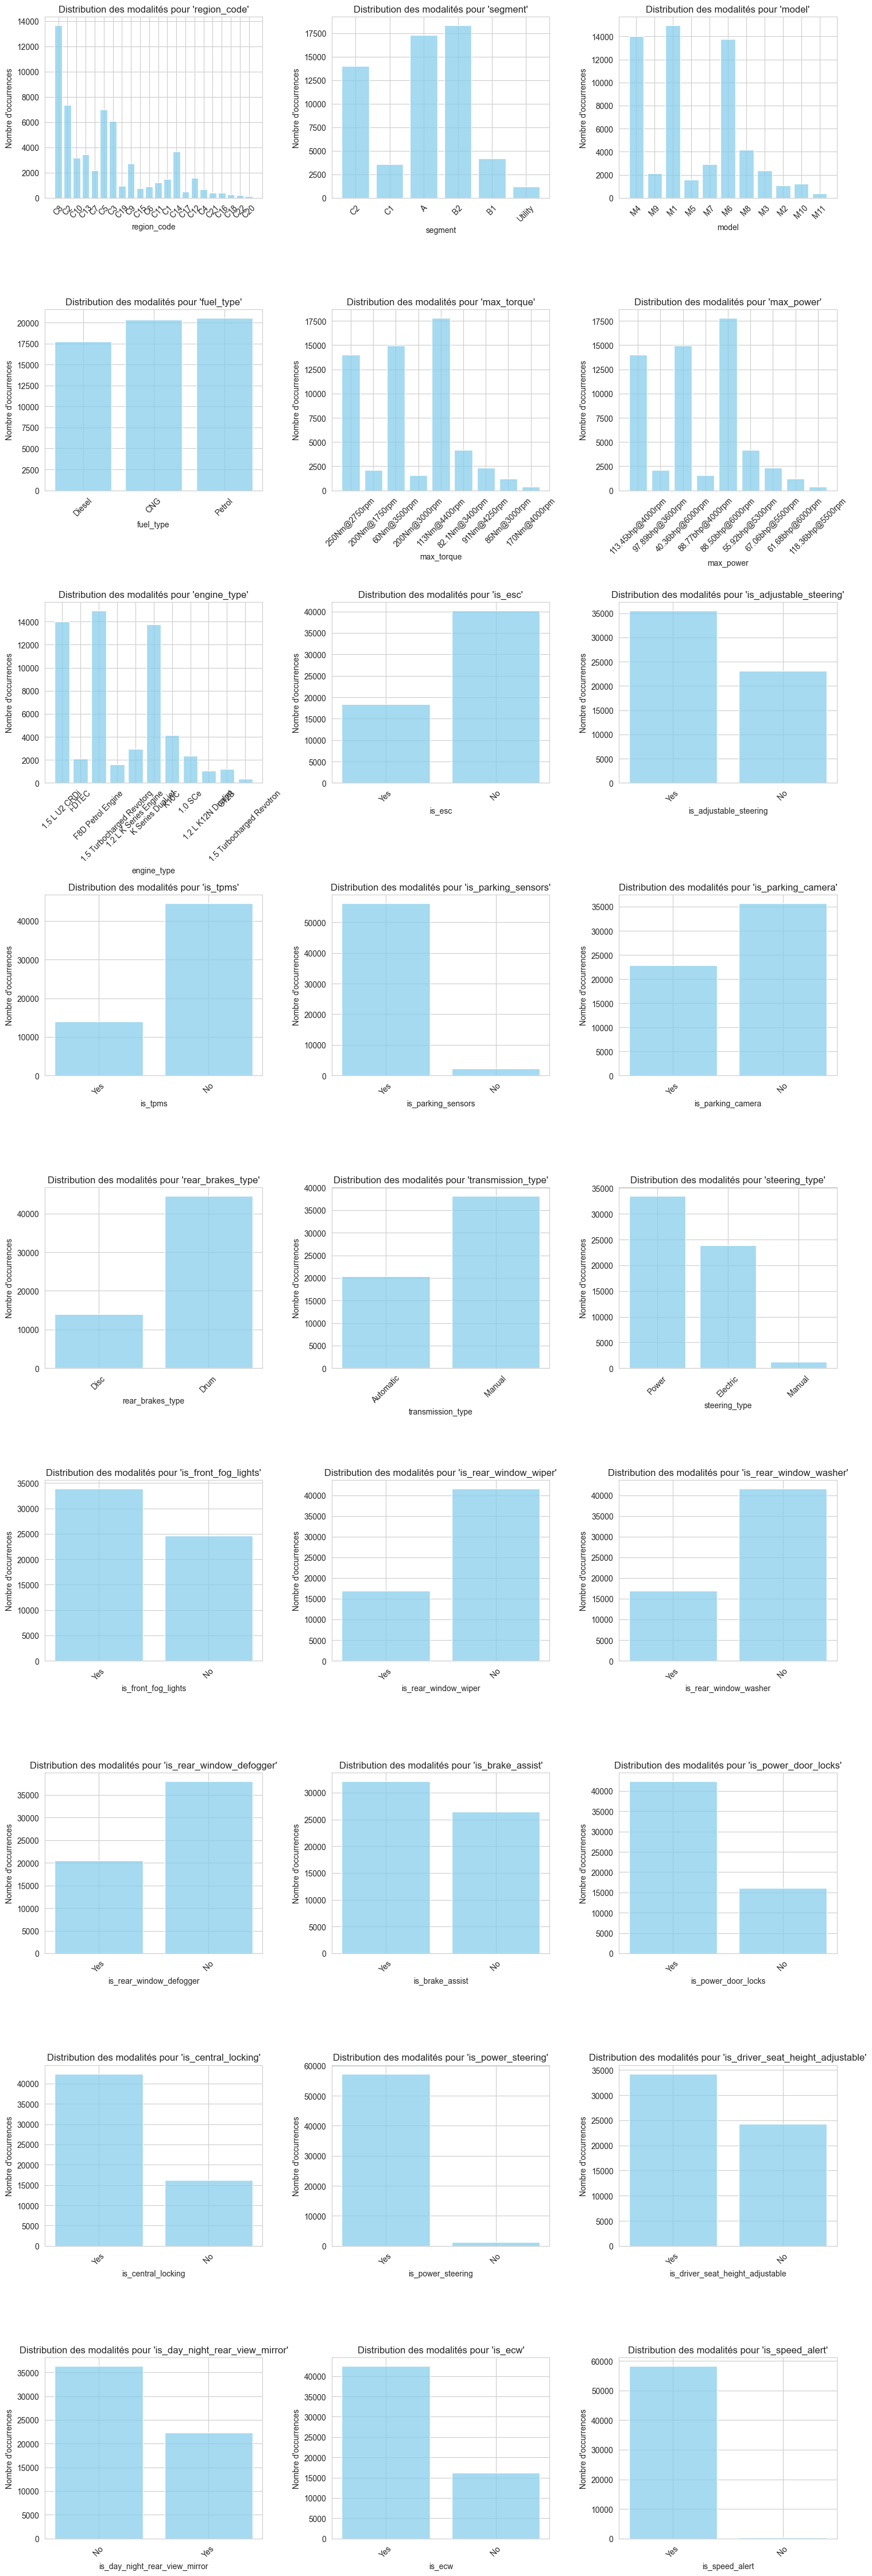

In [11]:
data_analysis.cat_hist()

## Boxplot des valeurs numériques

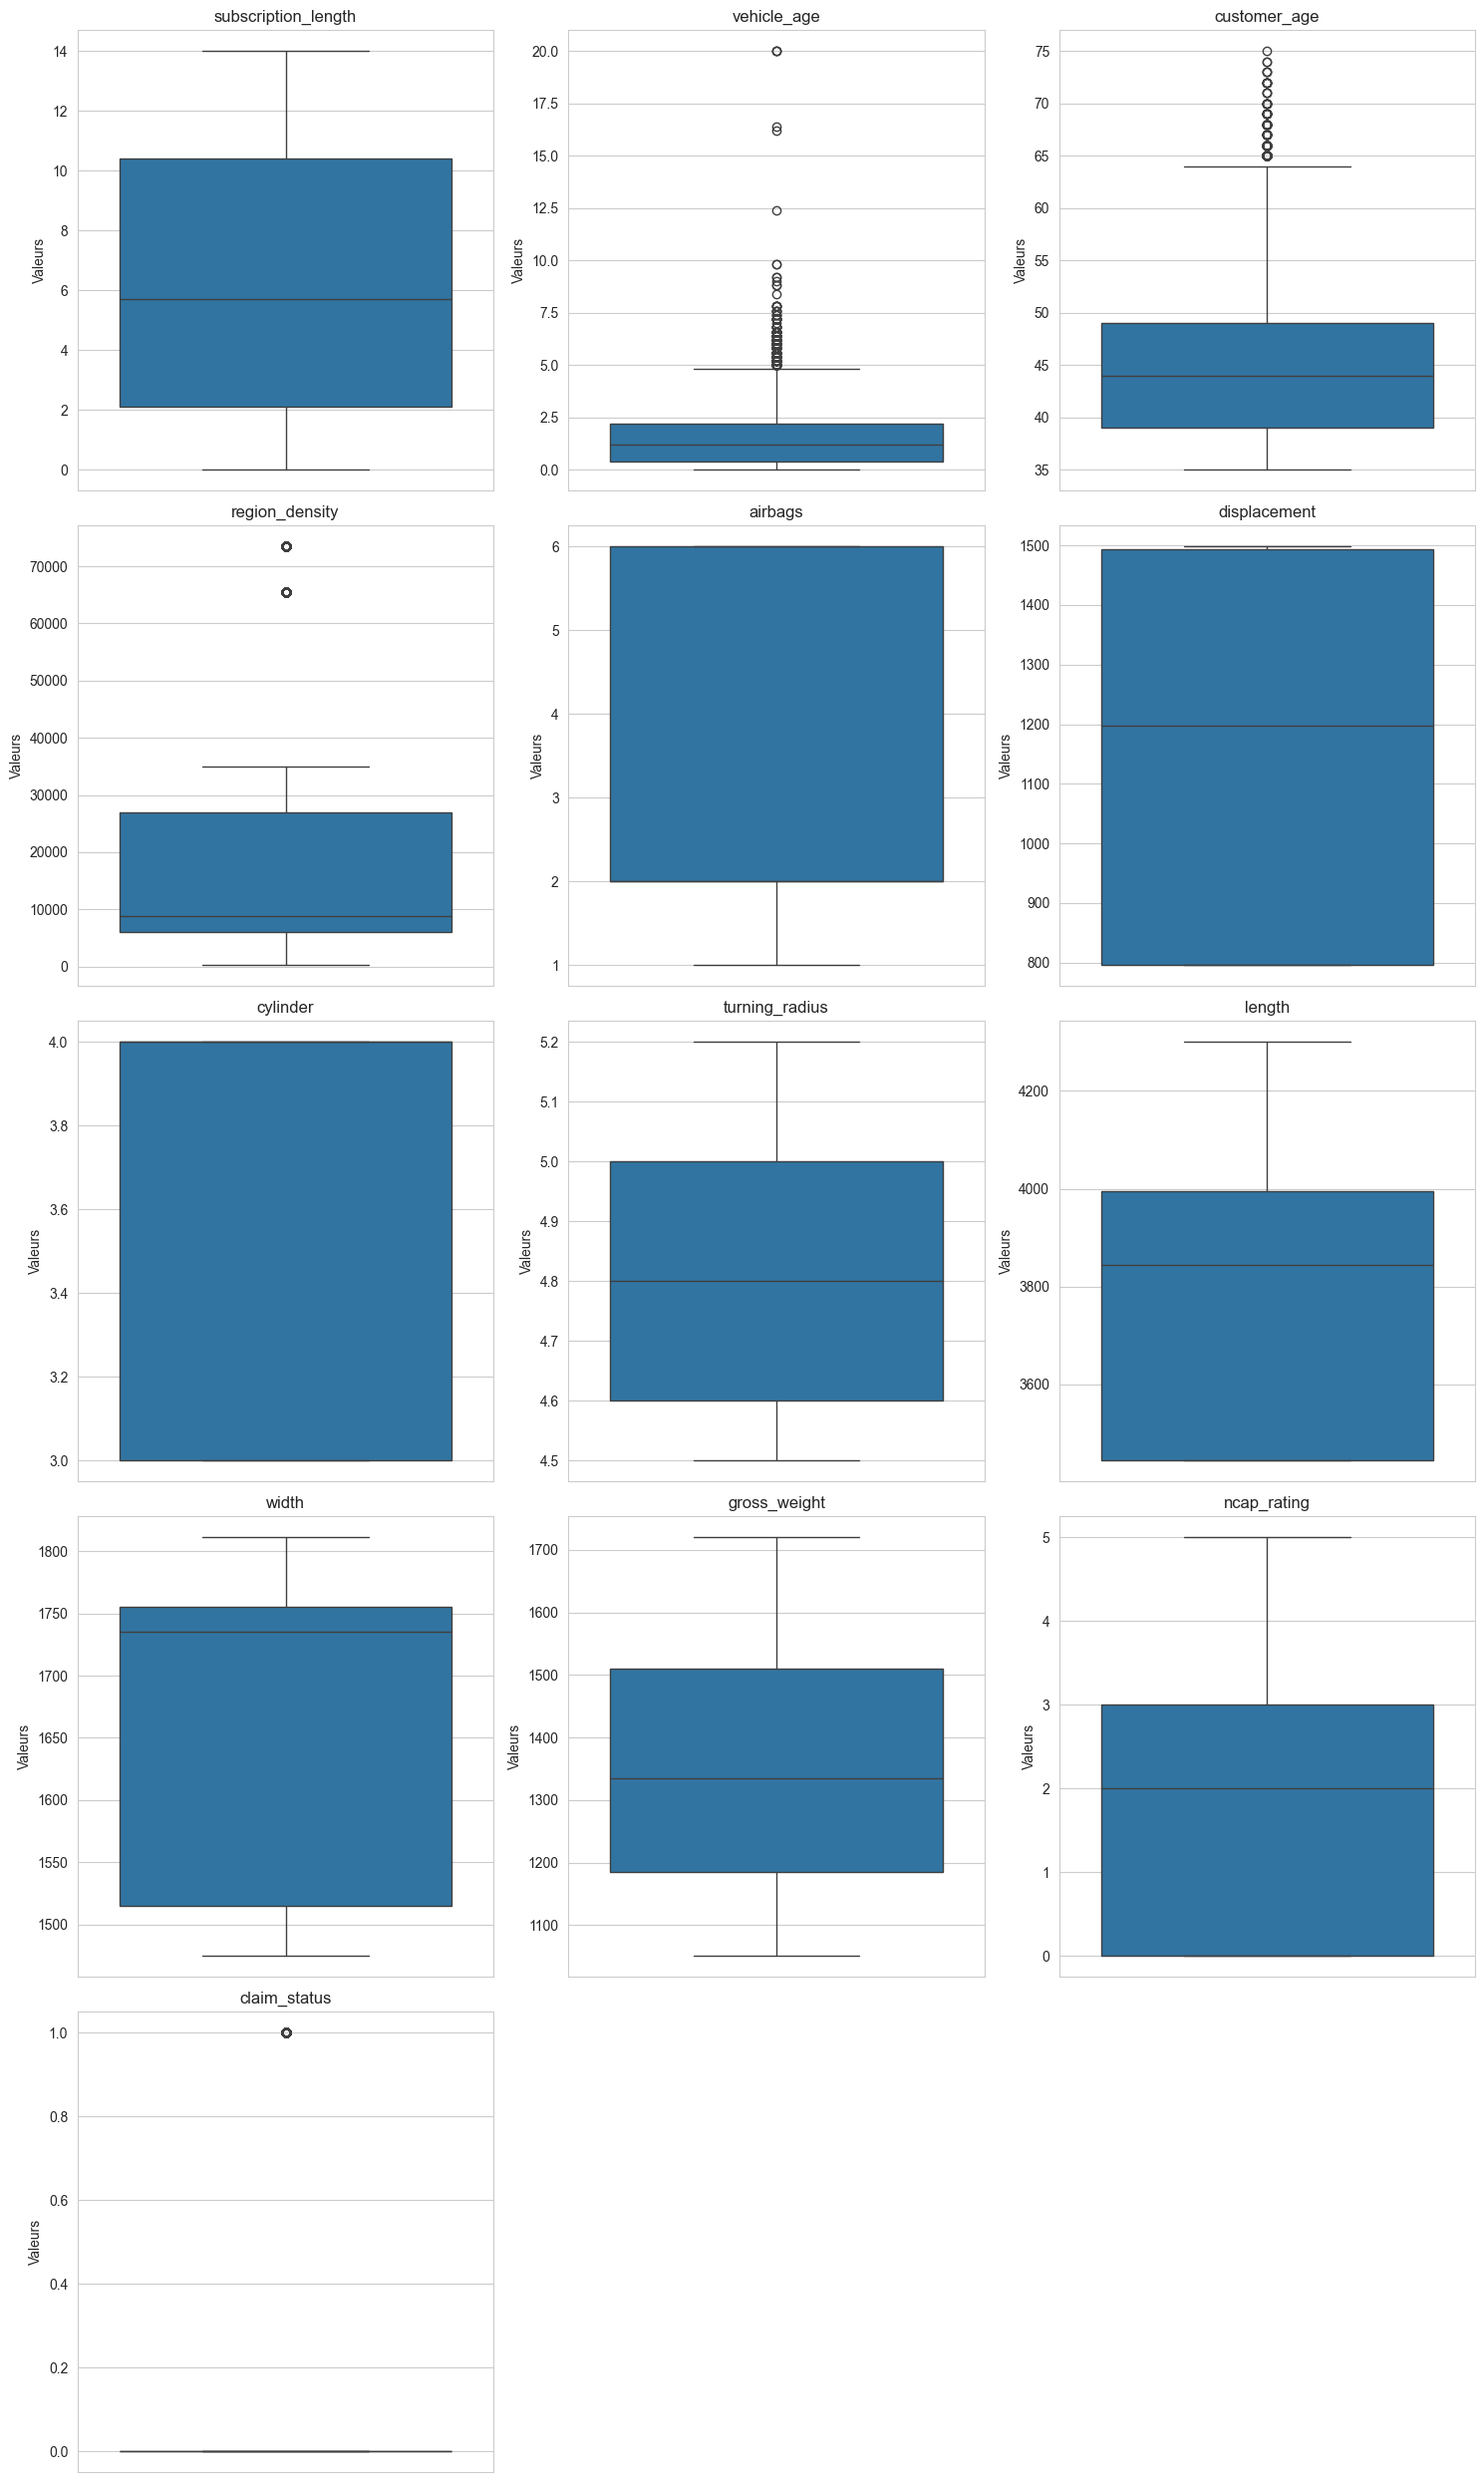

In [12]:

data_analysis.num_boxplot()


La variable véhicule contient et displacement contiennent des outliners.

En particulier, véhicule en a un nombre assez important, il serait judicieux par la suite de les traiter

## Correlation HeatMap


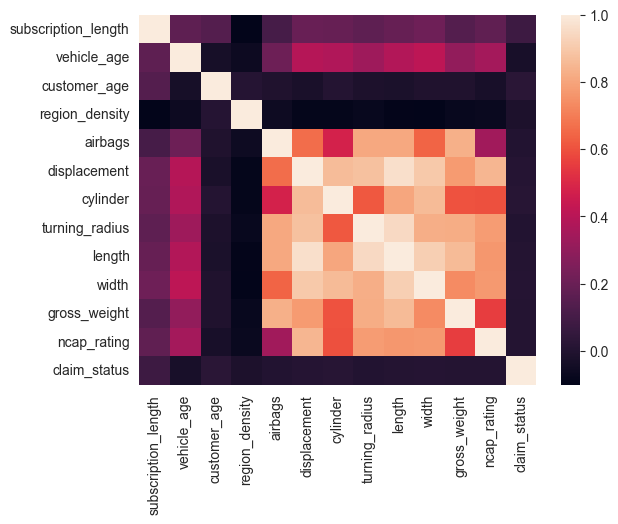

In [106]:

data_analysis.corr_heatmap()

Toutes les variables numériques semblent ne pas etre correlé avec la variable cible claim_status.

La variable 'length' semble etre correlé fortement avec 'displacement', 'turning_radius', 'width', 'gross_weight'

Donc on pourrait plus tard essayer de les representer juste par une seule variable ex: 'lenght'

## Scatterplot

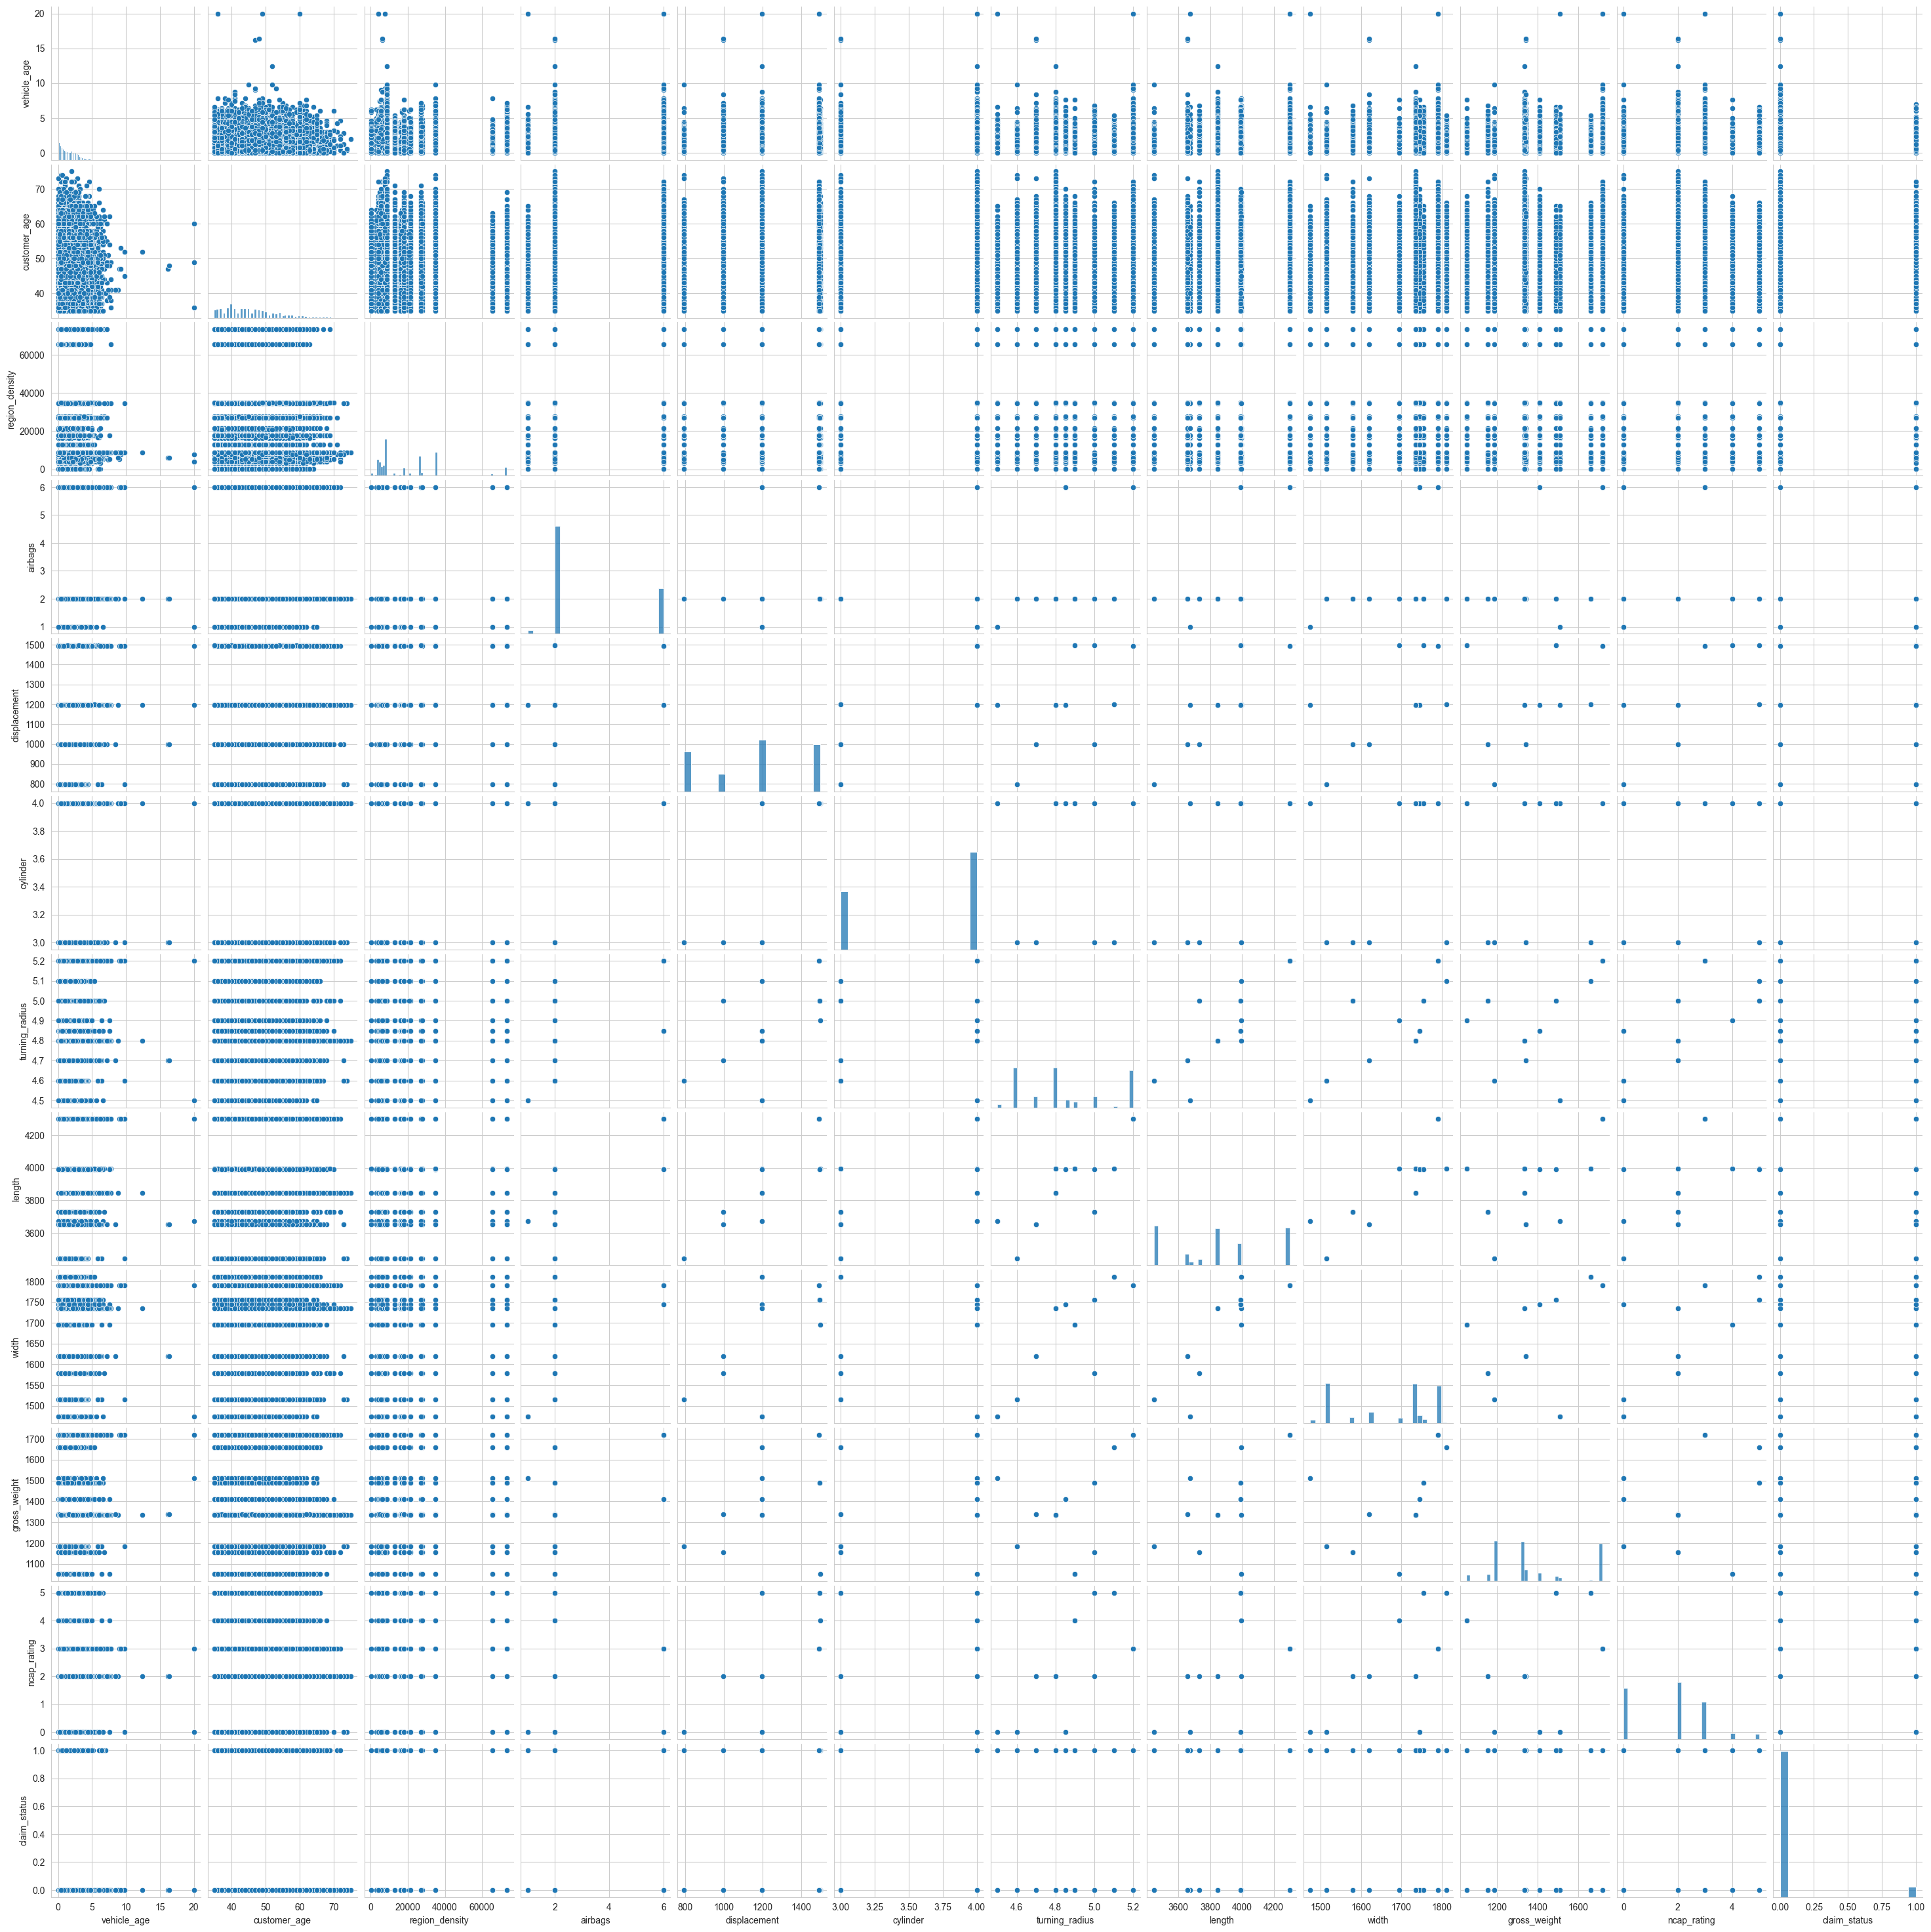

In [161]:

sns.pairplot(data=data)

In [29]:
# Encodage des variables categorielles

data_encoded = data.replace(['Yes','No'], [1, 0]).copy()

In [30]:
def extract_power_torque_features(df):
    def process_max_power(value):
        """ Extrait la puissance en bhp et le régime en rpm depuis max_power. """
        if isinstance(value, str):
            match = re.search(r"(\d+(?:\.\d+)?)bhp@(\d+)rpm", value)
            if match:
                bhp = float(match.group(1))  # Puissance en bhp
                rpm_bhp = int(match.group(2))  # Régime moteur en rpm
                return pd.Series([bhp, rpm_bhp])
        return pd.Series([None, None])

    def process_max_torque(value):
        """ Extrait le couple en Nm et le régime en rpm depuis max_torque, puis convertit en bhp estimé. """
        if isinstance(value, str):
            match = re.search(r"(\d+(?:\.\d+)?)Nm@(\d+)rpm", value)
            if match:
                torque_Nm = float(match.group(1))  # Couple en Nm
                rpm_torque = int(match.group(2))  # Régime moteur en rpm
                bhp_from_torque = (torque_Nm * rpm_torque) / 7027  # Conversion en bhp estimé
                return pd.Series([torque_Nm, rpm_torque, round(bhp_from_torque, 2)])
        return pd.Series([None, None, None])

    # Appliquer les transformations
    df[["bhp", "rpm_bhp"]] = df["max_power"].apply(process_max_power)
    df[["torque_Nm", "rpm_torque", "bhp_from_torque"]] = df["max_torque"].apply(process_max_torque)

    # Supprimer les colonnes originales
    df = df.drop(columns=["max_power", "max_torque"])

    return df

In [31]:
data_encoded = extract_power_torque_features(data_encoded)

In [32]:
def extract_model_number(df):
    def extract_number(value):
        """ Extrait le chiffre après 'M' dans la colonne model. """
        match = re.search(r"M(\d+)", value)  # Recherche du chiffre après "M"
        if match:
            return int(match.group(1))  # Convertir en entier
        return None  # Si pas trouvé

    df["model_number"] = df["model"].apply(extract_number)  # Appliquer la transformation

    # Supprimer la colonne originale "model" après extraction
    df = df.drop(columns=["model"])
    
    return df

In [33]:
data_encoded = extract_model_number(data_encoded)

In [34]:
categorical_data_2 = data_encoded.select_dtypes("object")
categorical_data_2

,region_code,segment,fuel_type,engine_type,rear_brakes_type,transmission_type,steering_type
0,C8,C2,Diesel,1.5 L U2 CRDi,Disc,Automatic,Power
1,C2,C1,Diesel,i-DTEC,Drum,Manual,Electric
2,C8,C2,Diesel,1.5 L U2 CRDi,Disc,Automatic,Power
3,C10,A,CNG,F8D Petrol Engine,Drum,Manual,Power
4,C13,B2,Diesel,1.5 Turbocharged Revotorq,Drum,Manual,Electric
...,...,...,...,...,...,...,...
58587,C5,B2,Petrol,K Series Dual jet,Drum,Manual,Electric
58588,C3,C2,Diesel,1.5 L U2 CRDi,Disc,Automatic,Power
58589,C8,B2,Petrol,K Series Dual jet,Drum,Manual,Electric
58590,C8,B2,Petrol,K Series Dual jet,Drum,Manual,Electric


In [35]:
for cat in categorical_data_2 :
    columns_array = data_encoded[cat].to_numpy().reshape(-1,1)
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first').fit(columns_array)
    data_enc = one_hot_encoder.transform(columns_array)
    df_enc = pd.DataFrame(data_enc, columns = one_hot_encoder.get_feature_names_out([cat]))
    data_encoded = pd.concat([data_encoded,df_enc],axis=1)
    data_encoded = data_encoded.drop(columns=cat)
data_encoded.head()

,subscription_length,vehicle_age,customer_age,region_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,turning_radius,length,width,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,bhp,rpm_bhp,torque_Nm,rpm_torque,bhp_from_torque,model_number,region_code_C10,region_code_C11,region_code_C12,region_code_C13,region_code_C14,region_code_C15,region_code_C16,region_code_C17,region_code_C18,region_code_C19,region_code_C2,region_code_C20,region_code_C21,region_code_C22,region_code_C3,region_code_C4,region_code_C5,region_code_C6,region_code_C7,region_code_C8,region_code_C9,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,fuel_type_Diesel,fuel_type_Petrol,engine_type_1.2 L K Series Engine,engine_type_1.2 L K12N Dualjet,engine_type_1.5 L U2 CRDi,engine_type_1.5 Turbocharged Revotorq,engine_type_1.5 Turbocharged Revotron,engine_type_F8D Petrol Engine,engine_type_G12B,engine_type_K Series Dual jet,engine_type_K10C,engine_type_i-DTEC,rear_brakes_type_Drum,transmission_type_Manual,steering_type_Manual,steering_type_Power
0,9.3,1.2,41,8794,6,1,1,1,1,1,1493,4,5.2,4300,1790,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,0,113.45,4000.0,250.0,2750.0,97.84,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8.2,1.8,35,27003,2,0,1,0,1,1,1498,4,4.9,3995,1695,1051,1,0,0,1,0,1,1,1,1,1,1,1,4,0,97.89,3600.0,200.0,1750.0,49.81,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,9.5,0.2,44,8794,6,1,1,1,1,1,1493,4,5.2,4300,1790,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,0,113.45,4000.0,250.0,2750.0,97.84,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5.2,0.4,44,73430,2,0,0,0,1,0,796,3,4.6,3445,1515,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,40.36,6000.0,60.0,3500.0,29.88,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,10.1,1.0,56,5410,2,0,1,0,1,0,1497,4,5.0,3990,1755,1490,0,0,0,0,0,1,1,1,0,0,1,1,5,0,88.77,4000.0,200.0,3000.0,85.38,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [36]:
# Suppresion de la variable à estimer

data_encoded = data_encoded.drop(columns='claim_status')

In [37]:
# Isolation de 'claim_status'

claim_status = data['claim_status']

In [38]:

def plot_roc_auc_with_accuracy(models, X, y, test_size=0.20, random_state=42, print_scores=True):

    # Séparer les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    plt.figure(figsize=(10, 8))
    
    # Pour chaque modèle dans la liste
    for name, model in models:
  
        model.fit(X_train, y_train)
        
        proba = model.predict_proba(X_test)[:, 1]
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Calculer la courbe ROC et l'AUC
        fpr, tpr, _ = roc_curve(y_test, proba, pos_label=1)
        roc_auc = roc_auc_score(y_test, proba)
        
        # Tracer la courbe ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}, Acc = {accuracy:.2f})')
        
        if print_scores:
            print(f"{name}: AUC = {roc_auc:.2f}, Accuracy = {accuracy:.2f}")
            print("\nRapport de classification :")
            print(classification_report(y_test, y_pred))
            conf_matrix = confusion_matrix(y_test, y_pred)
            print(f"Matrice de confusion pour {name} :\n{conf_matrix}")
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Comparaison des courbes ROC avec AUC et Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [39]:
# Modèle testing

models = [
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=3000, random_state=42, n_jobs=-1)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42, n_jobs=-1)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Adaboost', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('HistGradient', HistGradientBoostingClassifier(random_state=42)),
]

Gradient Boosting: AUC = 0.64, Accuracy = 0.94

Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10973
           1       0.00      0.00      0.00       746

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719

Matrice de confusion pour Gradient Boosting :
[[10973     0]
 [  746     0]]
Logistic Regression: AUC = 0.59, Accuracy = 0.94

Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10973
           1       0.00      0.00      0.00       746

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719

Matrice de confusion pour Logistic Regression :
[[10973     0]
 [  746     0]]
Random Forest: AUC = 0.64, Accuracy 

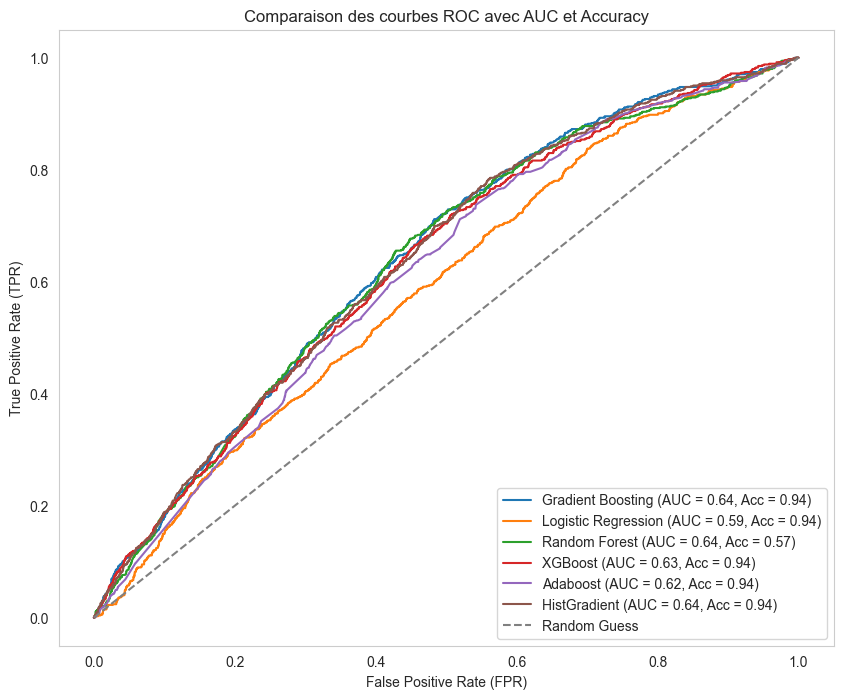

In [40]:

plot_roc_auc_with_accuracy(models, data_encoded, claim_status, test_size=0.20, random_state=42)

Aucun modèle ne se demarque particulierement en terme d'AUC ce qui traduit une faible capacité de discrimination.
Le score étant élevé, peut traduire une classe largement majoritaire donc un déséquilibre des classes.

<Axes: xlabel='claim_status', ylabel='Frequency'>

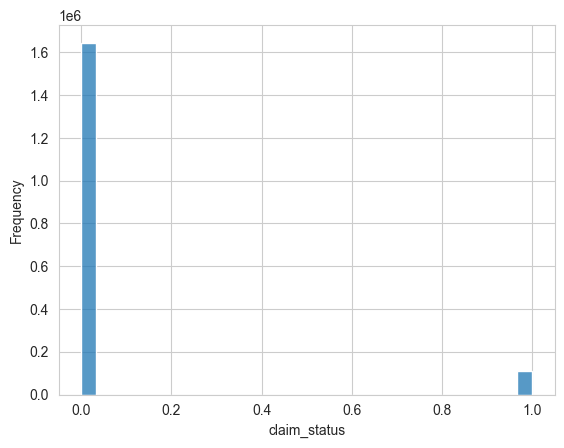

In [41]:
# Visualisation de la repartition des classes

sns.histplot(data=claim_status, stat='frequency', bins = 30)

Nos classes sont effectiment déséquilibré avec plus de 80-90% des données étant (0).
Procédons à un surechantillonnage pour essayer de palier à cela en utilisant le SMOTE (Synthetic Minority Oversampling Technique).

In [42]:

def plot_roc_auc_with_accuracy_SMOTEENN(models, X, y, test_size=0.25, random_state=42, print_scores=True):

    # Séparer les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    smoteen = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smoteen.fit_resample(X_train, y_train)
    print(y_train_resampled.value_counts())

    plt.figure(figsize=(10, 8))
    
    # Pour chaque modèle dans la liste
    for name, model in models:
  
        model.fit(X_train_resampled, y_train_resampled)
        
        proba = model.predict_proba(X_test)[:, 1]
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Calculer la courbe ROC et l'AUC
        fpr, tpr, _ = roc_curve(y_test, proba, pos_label=1)
        roc_auc = roc_auc_score(y_test, proba, average='weighted')
        
        # Tracer la courbe ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}, Acc = {accuracy:.2f})')
        
        if print_scores:
            print(f"{name}: AUC = {roc_auc:.2f}, Accuracy = {accuracy:.2f}")
            print("\nRapport de classification :")
            print(classification_report(y_test, y_pred))
            conf_matrix = confusion_matrix(y_test, y_pred)
            print(f"Matrice de confusion pour {name} :\n{conf_matrix}")
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Comparaison des courbes ROC avec AUC et Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

claim_status
0    43871
1    43871
Name: count, dtype: int64
Gradient Boosting: AUC = 0.63, Accuracy = 0.90

Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10973
           1       0.14      0.12      0.13       746

    accuracy                           0.90     11719
   macro avg       0.54      0.53      0.54     11719
weighted avg       0.89      0.90      0.89     11719

Matrice de confusion pour Gradient Boosting :
[[10430   543]
 [  659    87]]
Logistic Regression: AUC = 0.59, Accuracy = 0.56

Rapport de classification :
              precision    recall  f1-score   support

           0       0.95      0.56      0.70     10973
           1       0.08      0.55      0.14       746

    accuracy                           0.56     11719
   macro avg       0.51      0.56      0.42     11719
weighted avg       0.89      0.56      0.67     11719

Matrice de confusion pour Logistic Regression :
[[6127

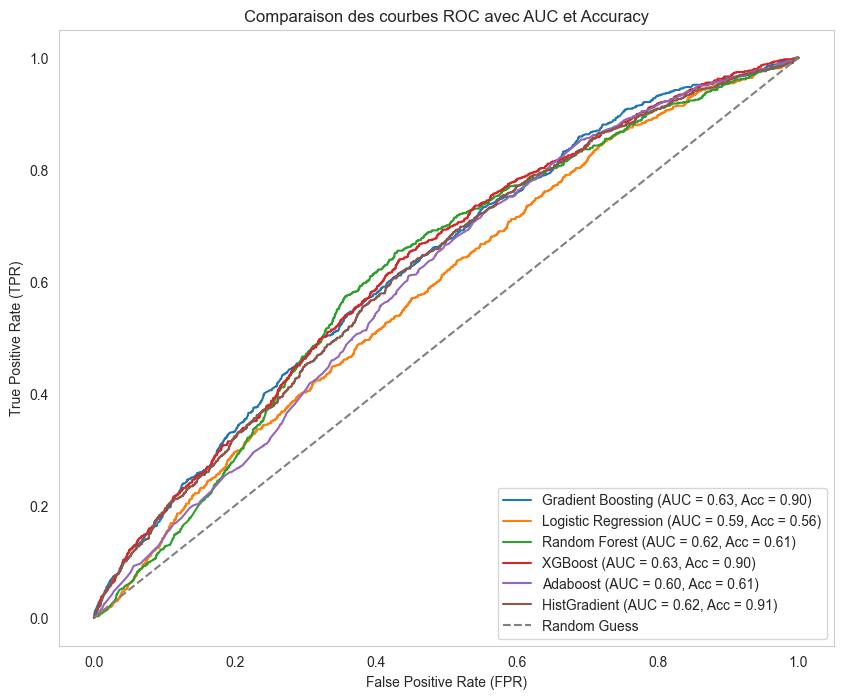

In [43]:
plot_roc_auc_with_accuracy_SMOTEENN(models, data_encoded, claim_status, test_size=0.2, random_state=42)

On ne note pas une amélioration notable même en surechantillonant nos données.

On va utiliser RF pour la suite car il a de bon score en recall ce qui nous intéresse car le cout de ne pas predire un sinistre est considéré élevé, si c'était le cout d'une fausse alerte (faux positif) qui etait important, on irait avec precision et si on cherche un équilibre on pourrait aller avec f1-score

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data_encoded, claim_status, test_size = 0.2, random_state=42)

In [ ]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_depth=5, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1,
                       random_state=42)

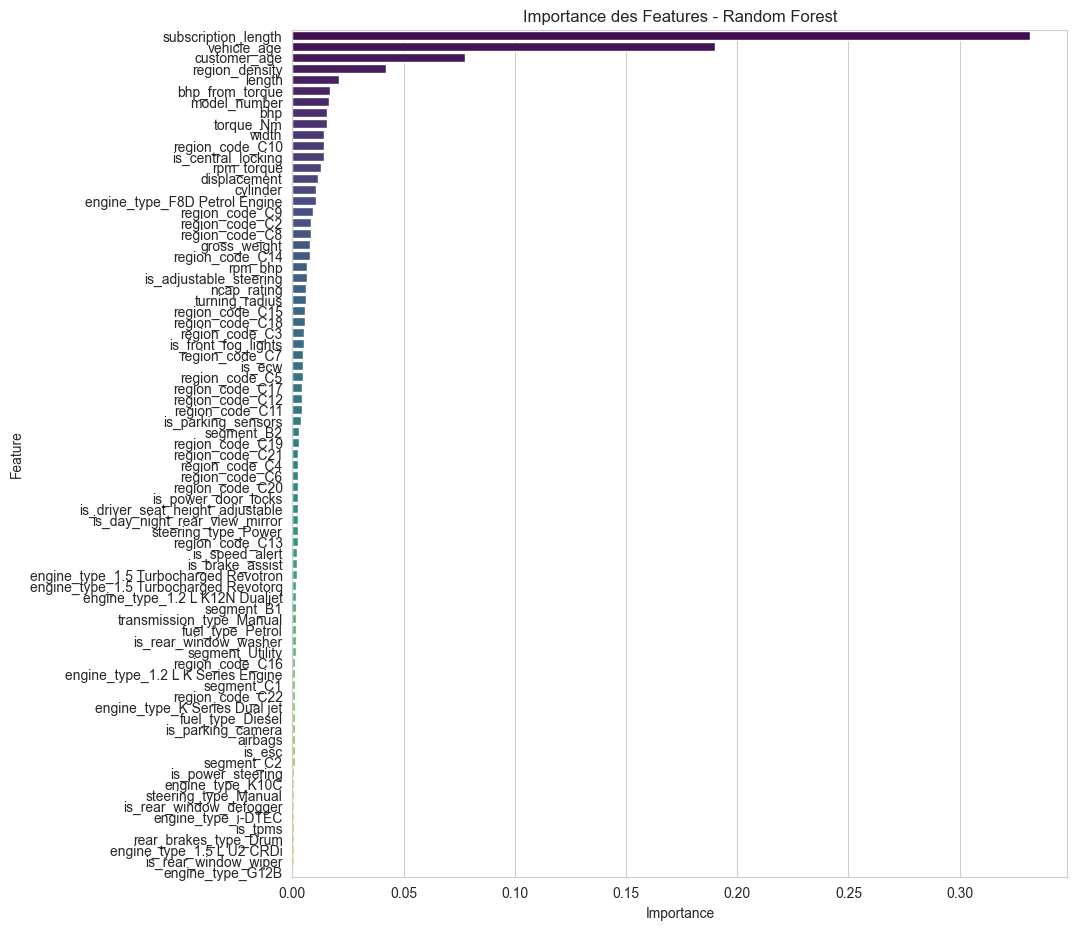

                      Feature  Importance
0         subscription_length    0.331866
1                 vehicle_age    0.189900
2                customer_age    0.077507
3              region_density    0.041881
13                     length    0.020882
..                        ...         ...
7                     is_tpms    0.000751
73      rear_brakes_type_Drum    0.000699
65  engine_type_1.5 L U2 CRDi    0.000694
17       is_rear_window_wiper    0.000649
69           engine_type_G12B    0.000193

[77 rows x 2 columns]


In [ ]:
feature_importances = rfc.feature_importances_

features_df = pd.DataFrame({'Feature': data_encoded.columns, 'Importance': feature_importances})

features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 11))
sns.barplot(x=features_df['Importance'], y=features_df['Feature'], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importance des Features - Random Forest")
plt.show()

print(features_df)


RandomForestClassifier: AUC = 0.64, Accuracy = 0.57

Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.57      0.71     10973
           1       0.09      0.66      0.16       746

    accuracy                           0.57     11719
   macro avg       0.53      0.61      0.44     11719
weighted avg       0.91      0.57      0.68     11719

Matrice de confusion pour RandomForestClassifier :
[[6220 4753]
 [ 257  489]]


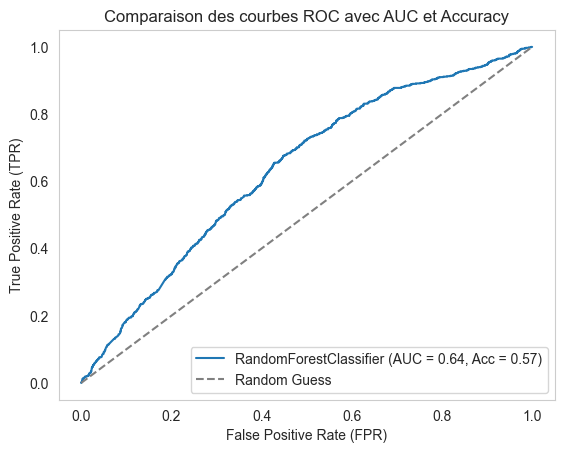

In [71]:
name = 'RandomForestClassifier'

proba = rfc.predict_proba(X_test)[:, 1]

y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Calculer la courbe ROC et l'AUC
fpr, tpr, _ = roc_curve(y_test, proba, pos_label=1)
roc_auc = roc_auc_score(y_test, proba, average='weighted')

# Tracer la courbe ROC
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}, Acc = {accuracy:.2f})')

print(f"{name}: AUC = {roc_auc:.2f}, Accuracy = {accuracy:.2f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matrice de confusion pour {name} :\n{conf_matrix}")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Comparaison des courbes ROC avec AUC et Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Modèle de tarification simpliste

   Puisque que l'on a predit le risque d'un assuré, pour faire ma tarification je n'ai plus qu'a soit
   avec assez de donnée faire un ML pour prédire le cout annuel en sinistre ou si j'ai la loi, la simuler et faire un monte-carlo
   Je pourrais juste utiliser la moyenne de mnt_sinistres ci-dessous mais je passerai par une simulation de la loi


In [72]:
class Tarification:
   def __init__(self) -> None:
      pass
   def tarificate(self, model, X, mnt_sinistres) :

      proba_sinistre = model.predict_proba(X)[:,1]
      self.proba_sinistre = proba_sinistre
      self.mnt_sinistres = mnt_sinistres
      prime = proba_sinistre * mnt_sinistres.mean()
      return prime

In [73]:
mnt_sinistres = pd.read_csv('database/insurance_claims_just_for_amount.csv')['total_claim_amount']

tarification_simple = Tarification()

# Modele Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rfc.fit(data_encoded, claim_status)


RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [ ]:
prime_pure = tarification_simple.tarificate(model=rfc, 
                               X=data_encoded.to_numpy(), 
                               mnt_sinistres=mnt_sinistres)

<Axes: ylabel='Probability'>

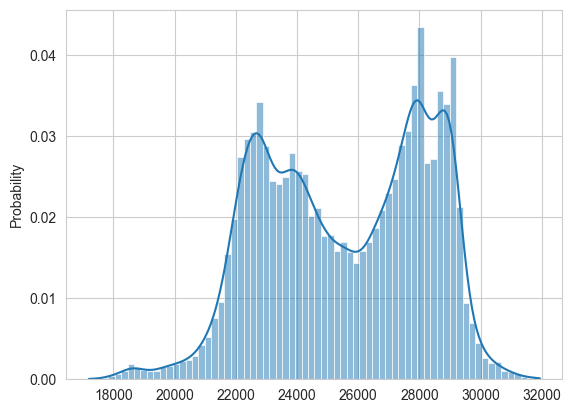

In [75]:
# Histogramme de repartition des primes et du risque accident

sns.histplot(data=prime_pure, stat='probability', bins=70, kde=True)

<Axes: ylabel='Count'>

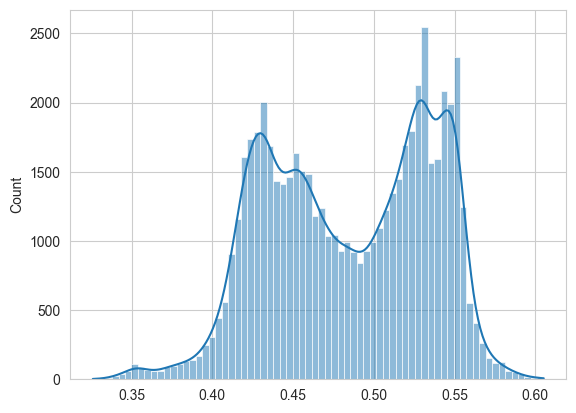

In [ ]:
sns.histplot(data=tarification_simple.proba_sinistre, kde=True, bins=70)

## SEGMENTATION ?

En analysant ce graphique de la répartition des fréquences, on peut effectivement identifier deux groupes principaux :

- Un premier groupe avec des fréquences relativement faibles, entre 0,35 et 0,50 environ. C'est le groupe le plus important en nombre.

- Un second groupe avec des fréquences plus élevées, entre 0,50 et 0,60 environ. Bien que moins nombreux, ce groupe présente un risque plus important.

Cette observation suggère qu'il serait pertinent de différencier les tarifs d'assurance entre ces deux groupes :

- Pour le premier groupe à faible fréquence, on pourrait appliquer des primes plus avantageuses.
- Pour le second groupe à fréquence plus élevée, des primes plus élevées seraient justifiées afin de refléter leur profil de risque plus important.
Cette segmentation en deux groupes principaux permettrait ainsi d'ajuster les tarifs de manière plus fine et équitable, tout en restant compétitif pour le groupe à faible risque

## Test de Robustesse et CV

### 1. Test de Robustesse - Cross Validation

In [136]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
scoring = ['accuracy', 'precision', 'average_precision', 'f1_weighted', 'f1', 'precision_weighted']
cross_score = cross_validate(rfc, data_encoded, claim_status, scoring=scoring)


In [137]:
pd.DataFrame(cross_score)

,fit_time,score_time,test_accuracy,test_precision,test_average_precision,test_f1_weighted,test_f1,test_precision_weighted
0,3.789343,0.308403,0.569161,0.094663,0.094479,0.674781,0.165868,0.905880
1,3.585588,0.329274,0.573172,0.089575,0.097631,0.678603,0.156492,0.900796
2,3.676447,0.271188,0.560847,0.093397,0.101821,0.667802,0.164068,0.905860
3,3.545211,0.262749,0.581925,0.095517,0.110197,0.685538,0.166695,0.905386
4,1.844678,0.120235,0.567076,0.091167,0.106527,0.673309,0.159682,0.902825


Les scores obtenus en CV sont assez interessant

### 2. CV pour les hyperparamètres.

In [96]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

rfc = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

param_dist = {
    'n_estimators': randint(50, 200), 
    'max_depth': [3, 5, 10, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    rfc, param_distributions=param_dist, n_iter=100, cv=cv, scoring='recall', n_jobs=-1, random_state=42, verbose=2
)

random_search.fit(data_encoded, claim_status)

print("Meilleurs hyperparamètres :", random_search.best_params_)
print("Meilleur score Recall :", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Meilleurs hyperparamètres : {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 6, 'n_estimators': 193}
Meilleur score Recall : 0.6670237650200266


<Axes: ylabel='Count'>

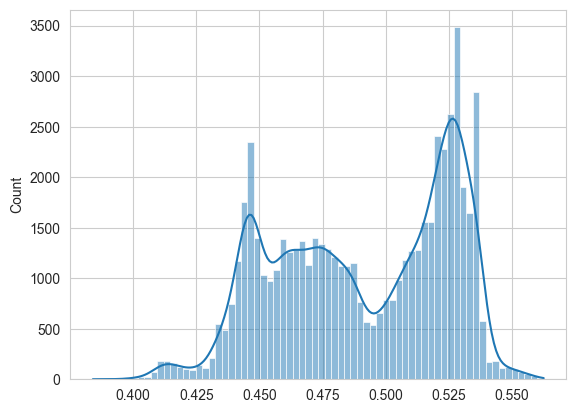

In [97]:
tarification_sp = Tarification()

prime_p = tarification_sp.tarificate(model=random_search.best_estimator_, 
                               X=data_encoded.to_numpy(), 
                               mnt_sinistres=mnt_sinistres)
sns.histplot(data=tarification_sp.proba_sinistre, kde=True, bins=70)